## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
  !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2022-12-22 19:30:32--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2022-12-22 19:30:32 (6.74 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
assert len(token_to_idx) == len(idx_to_token)


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
def to_matrix(pieces, max_length=None):
  if max_length == None: 
    max_length = max(map(len, pieces))

  text_ix = np.zeros((len(pieces), max_length), dtype='int32')
  for i in range(len(pieces)): 
    line_ix = [token_to_idx[c] for c in pieces[i]]
    text_ix[i, :len(line_ix)] = line_ix
  return text_ix

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
device = 'cuda'
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)
        assert h_next.size() == h_prev.size()
        logits = self.rnn_to_logits(h_next)
        return h_next, F.log_softmax(logits, -1)
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True).to(device)

In [9]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [10]:
def get_shifts(num, start=0, piece_len=100, step=1):
  result = []
  for i in range(num): 
    if len(text) - 1 <= start + piece_len:
      print("ooops")
      break
    result.append(text[start:start+piece_len])
    start += step
  return result

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F
device = 'cuda'

In [14]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from random import sample
from tqdm import trange

char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
def training_loop(rnn, opt, epochs=30):
  loss_history = []
  for epoch in range(epochs):
    loss_this_epoch = 0
    for batch_idx in trange(NUM_BATCHES):
      pieces = get_shifts(BATCH_SIZE, start=batch_idx * BATCH_SIZE, piece_len=MAX_LEN)
      samples = torch.tensor(to_matrix(pieces), dtype=torch.int64).to(device)
      batch_ix = samples[:, :-1]
      opt.zero_grad()
      logp_seq = rnn_loop(rnn, batch_ix)
      actual_next_tokens = samples[:, 1:]
      predictions_logp = logp_seq
      logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
      loss = -logp_next.mean()
      #loss_history.append(loss.detach().cpu().numpy())
      loss_this_epoch += loss.detach().cpu().numpy()
      loss.backward()
      opt.step()
    loss_this_epoch /= NUM_BATCHES
    print('Training epoch: {} Loss: {}'.format(epoch, loss_this_epoch))
    loss_history.append(loss_this_epoch)
    clear_output(True)
    plt.plot(loss_history,label='loss')
    plt.legend()
    plt.show()

  return loss_history

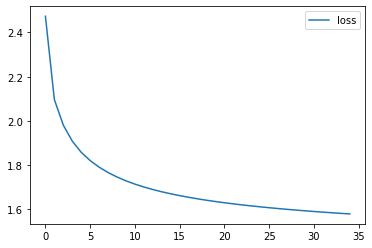

In [15]:
MAX_LEN = 120
BATCH_SIZE = 200
NUM_BATCHES = (len(text) - MAX_LEN) // BATCH_SIZE
from tqdm import tqdm
tqdm._instances.clear()
loss_history = training_loop(char_rnn, opt, 35)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [16]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=120, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)
  
    for i in range(len(seed_phrase) - 1):
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
  
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [24]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase='eyes', max_length=500, temperature=0.8))


eyes i no perverse bear me rease be pulnitur do of my plonn'l would hose i my becilous of the worthed my feartes'd not to deens heart thou did to least;
  then love that show;
    and my soud;
  which face,
  wher comest,
  and your thou dout.

  cxxiise,
  the that that swoul i thy would worth, on thy self exceswers'd so one it seest thou dost do it strease,
  for the thou be your such some i see sakent, for all host i helfichs,
  but thes but whou love's fresping how eyes i chouds, in lainnt:



### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

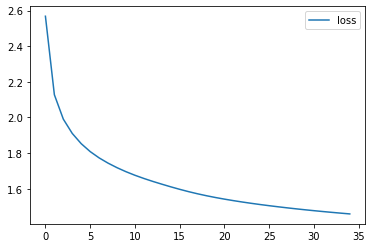

In [25]:
device = 'cuda'
class LSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
   
        x_emb = self.embedding(x)
        h_next = self.rnn_update(x_emb, h_prev)
        logits = self.rnn_to_logits(h_next[0])
        return h_next, F.log_softmax(logits, -1)
    def initial_state(self, batch_size):
        return [torch.zeros(batch_size, self.num_units, requires_grad=True).to(device) for i in range(2)]
lstm_rnn = LSTMCell().to(device)
lstm_opt = torch.optim.Adam(lstm_rnn.parameters())
loss_history_lstm = training_loop(lstm_rnn, lstm_opt, 35)


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [26]:
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=0.1))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=0.2))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=0.5))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=1))
print("\n***\n")
print(generate_sample(lstm_rnn, seed_phrase='love', max_length=500, temperature=2))


***

love thee thee thee thee thee to thee,
    the world thee the world thee the world thee thee thee thee thee to me thee,
  the world thee the world thee that the world thee thee thee thee thee strange,
  the world thee the world thee the world thee thee thee thee thee to thee,
  and the world thee the world thee the world thee thee to thee thee thee to me thee thee strange thee thee,
  the world thee that the world thee the world thee thee thee thee thee thee strange,
  the world thee the world t

***

love thee the world so thee,
  that the world thee i so contercounter'd still i thee,
  the world thee the worth thy summer's far is thee thee strange doth so be thee sweet despity,
  when i have thou art the world to thee thee strange,
  to me what the world thee the make thee the world my see,
    the world thee the world that i should thee i should thee thee to my love,
    the world that i so be the first the make they thee thee strong;
  and the surving the world in thee i have

With low temperature, we often see repeat of the most frequent words so that's why we see so many thee thee thee....

For 0.2 we still see the similar things : the worlds, thee...

0.5 is ok, not much repetition but still no sense

1 is good. Good structure and grammar 

2.0 - it doesnt work and text doesnt make any sense

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [27]:
torch.save(lstm_rnn, 'model')


In [28]:
loaded = torch.load('model')


In [29]:
print(generate_sample(loaded, seed_phrase='love', max_length=500, temperature=1))


love doth new is not so,
  his not to can that i arn i sarfelion my dust thee thee.
    when though never so lacks,
  but it awoutlest so doth teerses refore?
  thou art thy drast everse do charght'd, and they loss,
  for this sadon form thy sweet may i grade,
  in this far heaven's me proft noo still me
  worthess no dief not forting hours thou know'st;
  weit i dear that fairth lace, what pose in thy rudy;
  but by this bust in stay when the pently dobh hiss,
  when thy songrons kinds, like wh


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)